In [1]:
# load packages
library(edgeR)
library(sva)
library(fgsea)
library(tidyr)
source('../ABCA7lof2//degs.r')
set.seed(5)

Loading required package: limma

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel



In [106]:
# functions
compute_degs = function (counts.df, mod1, mod0,var, n.sv = NULL)
{
    dge <- DGEList(counts = counts.df)
    dge <- calcNormFactors(dge)

    v <- voom(dge, design = mod1)
    if (is.null(n.sv)) {
        n.sv <- num.sv(v$E, mod1, method = "be")
    }
    svobj <- sva(v$E, mod1, mod0, n.sv = n.sv)
    mod1 <- cbind(mod1, svobj$sv)
    v <- voom(dge, design = mod1)
    fit <- lmFit(v, design = mod1)
    fit <- eBayes(fit)
    #res1 <- topTable(fit, coef = "rs3752246", n = Inf, sort.by = "p")
    res1 <- topTable(fit, coef =var, n = Inf, sort.by = "p")
    return(list(res1 = res1, C = svobj$sv, mod=mod1))
}

In [75]:
# load Henne Holstege et al data
df = read.csv('../processed_data/holstege_et_al//41588_2022_1208_MOESM4_ESM.csv', skip = 2, header = TRUE)

# merge with ABCA7 variant info
variant_info = read.csv('../raw_data/ROSMAP_WGS/HIGHandMED_coding_annotations_syn11724057_subset.csv', check.names=FALSE)
variant_info$Variant = paste0(variant_info$CHROM,':',variant_info$POS,':',variant_info$REF_x, '>', variant_info$ALT_0)
df = df[,c('Variant', 'REVEL', 'LOF')]
var_info = merge(variant_info, df, by = 'Variant')
var_info = var_info[var_info$GENE=='ABCA7',]


# # add variant categorization info
# var_info$REVEL[is.na(var_info$REVEL)] = 0
# var_info$stage1 = ifelse(var_info$LOF.y==1, 1, 0)
# var_info$stage2 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.75)), 1, 0)
# var_info$stage3 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.50)), 1, 0)
# var_info$stage4 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.25)), 1, 0)
# var_info$stage5 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.40)), 1, 0)
# var_info$stage6 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.30)), 1, 0)
# var_info$stage7 = ifelse(((var_info$LOF.y==1) | (var_info$REVEL>=.20)), 1, 0)

# # # # subset var_info
#var_info = var_info[(var_info$EFFECT=='missense_variant') & var_info$MAF<0.05,]

# # compute / add burden scores
#stages = var_info[,c('LOF.y', 'stage1', 'stage2', 'stage3', 'stage4', 'stage5', 'stage6', 'stage7')]

genotypes = var_info[,unlist(lapply(names(var_info), function(x) sum(startsWith(x, c('ROS', 'MAP', 'SM')))))>0]
genotypes[genotypes=='0/0']=0
genotypes[genotypes=='0/1']=1
genotypes[genotypes=='1/0']=1
genotypes[genotypes=='1/1']=2
df = apply(genotypes,2, function(x){as.numeric(x)})

variant_categories = as.data.frame(colSums(df[var_info$LOF.y==1,]))
# variant_categories$stage1 = colSums(df[stages$stage1==1,])
# variant_categories$stage2 = colSums(df[stages$stage2==1,])
# variant_categories$stage3 = colSums(df[stages$stage3==1,])
# variant_categories$stage4 = colSums(df[stages$stage4==1,])
# variant_categories$stage5 = colSums(df[stages$stage5==1,])
# variant_categories$stage6 = colSums(df[stages$stage6==1,])
# variant_categories$stage7 = colSums(df[stages$stage7==1,])
# variant_categories$high = colSums(df[var_info$IMPACT=='HIGH',])                   
# # add common variant
temp = as.numeric(unlist(genotypes[var_info$ID=='rs3752246',]))                                  
temp = -1*(temp-2)
variant_categories$rs3752246 = temp
# variant_categories$rare_sums = colSums(df)
#variant_categories$weighted_sum = as.numeric(unlist(var_info$REVEL%*%df))

Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”


In [76]:
# load our large snRNAseq dataset
data = readRDS('../processed_data/mathys_et_al/all_summed_cts.rds')

# add variant data to metadata
meta = data$meta
meta = cbind(meta, variant_categories[meta$WGSid,])

In [77]:
# remove individuals from our snRNAseq cohort
all_data = readRDS('../processed_data/single_cell//stats_input_data_0825.rds')

keep = !meta$projid%in%rownames(all_data$summary)
meta = meta[keep,]
ncells = data$ncells[keep]
counts = data$counts[,keep]

In [78]:
expressed = all_data$expressed10

In [79]:
# add batch info
batch_ids = read.csv('../../ADSubtypes/metadata/Fastq_paths_432_PFC_HM_updated_edited.csv')
batch_ids = batch_ids[!duplicated(batch_ids$projid),]
rownames(batch_ids) = batch_ids$projid
meta$seq_batch = batch_ids[rownames(meta),'Batch']

In [81]:
# filter out individuals with too few cells per celltype
keep = ncells>=10
counts_indexed = counts[,keep]
meta_keep = meta[keep,]
meta_keep$niareagansc = as.numeric(meta_keep$niareagansc)

# filter
keep = (rowSums(is.na(meta_keep))==0) & !(is.na(meta_keep[,'colSums(df[var_info$LOF.y == 1, ])']) | (meta_keep[,'colSums(df[var_info$LOF.y == 1, ])']>0)) #& meta_keep$niareagansc%in%(unlist(list('3','4')))
meta_keep2 = meta_keep[keep,]
meta_keep2$apoe = ifelse(meta_keep2$apoe_genotype%in%c(34,44,24), 1, 0)
counts_keep2 = counts_indexed[,keep]
counts_keep2 = counts_keep2[rownames(counts_keep2)%in%expressed$Ex & rowSums(counts_keep2>0)>15,]

In [82]:
meta_keep2$rs3752246_binary = ifelse(meta_keep2$rs3752246>0, 1, 0)

table(meta_keep2$rs3752246_binary)


  0   1 
227 133 

In [16]:
# compute DEGs rs3752246
# remove any LOF individuals

meta_keep2$rs3752246_binary = ifelse(meta_keep2$rs3752246>0, 1, 0)

mod1 <- model.matrix(~rs3752246_binary + amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)
mod0 <- model.matrix(~ amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)

out = compute_degs(counts_keep2, mod1, mod0, 'rs3752246_binary')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [623]:
# compute fgsea results rs3752246
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [651]:
x = o[order(o$pval,decreasing=FALSE),]
x$leadingEdge = NULL

write.csv(x, '../processed_data/common_var/rs3755246_cluster_effects.csv')

In [634]:
write.csv(meta_keep2[, c('projid', 'WGSid', 'rs3752246_binary', 'amyloid', 'nft', 'msex', 'age_death', 'apoe', 'pmi', 'seq_batch', 'niareagansc')], '../processed_data/mathys_et_al/data_for_carles.csv', row.names=FALSE)

In [636]:
x = o[order(o$pval,decreasing=FALSE),]
x$leadingEdge = NULL

write.csv(x, '../processed_data/common_var/rs3755246_cluster_effects.csv')
write.csv(as.data.frame(scores), '../processed_data/common_var/rs3752246_binary_scores.csv')

In [655]:
var_info[var_info$ID=='rs3752246',1:2]

,Variant,Var.2,CHROM,POS,REF_x,ALT_0,ALT_1,ALT_2,FILTER_PASS,numalt,⋯,HGVS_C,HGVC_P,LOF.x,NMD,1000Gp3_AF,N -1/-1,N 0/0,N 0/1,N 0/2,N 0/3
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
60,19:1056492:G>C,11413,19,1056492,G,C,,,True,1,⋯,c.4580G>C,p.Gly1527Ala,,,0.825479,0,39,364,0,0


In [17]:
# specific paths
pathways = readRDS('../../ABCA7lof/processed_data/pathway_databases/pathways.rds')$all_paths

o = get_gset_names_by_category(c('lipid biosynthesis', 'lipid storage', 'lipid synthesis', 'response to lipid', 'Fatty Acyl-CoA Biosynthesis', 'Triglyceride Biosynthesis'), names(pathways))
temp2 = pathways[o]

In [136]:
o = fgsea(pathways = temp2, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [137]:
o[o$pval<0.05,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>


In [21]:
# specific paths
pathways = readRDS('../../ABCA7lof/processed_data/pathway_databases/pathways.rds')$all_paths

o = get_gset_names_by_category(c('oxidation', 'TCA', 'lipolysis'), names(pathways))
temp2 = pathways[o]

In [22]:
o = fgsea(pathways = temp2, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [26]:
o[o$pval<0.05,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
fatty acid beta-oxidation (GO:0006635),0.04769874,0.5196507,0.1095412,-0.4209796,-1.407266,38,"ECI2, PP....",-1.321493
fatty acid oxidation (GO:0019395),0.01440044,0.4032124,0.2005132,-0.4713915,-1.556346,36,"PPARD, A....",-1.841624


In [30]:
##### divide into low vs high ABCA7 expressors

In [116]:
x = cpm(counts_keep2)
index = meta_keep2$rs3752246_binary==0
m_2 = meta_keep2[index,]

In [124]:
lower = mean(x['ABCA7',index])-(.5*sd(x['ABCA7',index]))
higher = mean(x['ABCA7',index])+(.5*sd(x['ABCA7',index]))

In [125]:
sum(x['ABCA7',index]<lower)

[1] 67

In [126]:
sum(x['ABCA7',index]>higher)

[1] 57

In [127]:
m_2$grp = ifelse(x['ABCA7',index]<lower, 1, ifelse(x['ABCA7',index]>higher, 0, 2))

In [128]:
m_22 = m_2[m_2$grp!=2,]

In [132]:
c = counts_keep2[,index][,(m_2$grp!=2)]

In [133]:
mod1 <- model.matrix(~grp + amyloid +nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = m_22)
mod0 <- model.matrix(~ amyloid +nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = m_22)

out = compute_degs(c, mod1, mod0, 'grp')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

Number of significant surrogate variables is:  10 
Iteration (out of 5 ):1  2  3  4  5  

In [134]:
# compute fgsea results rs3752246
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

  |======================================================================| 100%



In [135]:
o

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
1,8.913374e-01,8.913374e-01,0.01534667,-0.2487520,-0.7442796,38,"PALB2, M....",-0.04995788
5,7.678571e-01,8.775510e-01,0.01751778,-0.2758804,-0.8254492,38,"POLA2, C....",-0.11471957
0,7.632979e-01,8.775510e-01,0.01760537,-0.2771649,-0.8292926,38,"OPRD1, D....",-0.11730595
2,4.955058e-01,7.928093e-01,0.02439950,-0.3409914,-0.9738983,31,"NADK, AC....",-0.30495123
3,2.916405e-01,5.832810e-01,0.03588380,0.3523708,1.0995666,43,"UBB, PSM....",0.53515220
6,1.158727e-01,3.089938e-01,0.05943045,0.5207493,1.3360347,18,"PTRH2, J....",0.93601893
4,2.388851e-03,9.555405e-03,0.43170770,-0.6941308,-1.7996712,20,"DDB2, PI....",-2.62181090
7,5.086930e-08,4.069544e-07,0.71951283,0.7428782,2.2819251,40,"NDUFA4, ....",7.29354426


In [110]:
x = o[order(o$pval,decreasing=FALSE),]
x$leadingEdge = NULL

write.csv(x, '../processed_data/common_var/exp_cluster_effects.csv')
write.csv(as.data.frame(scores), '../processed_data/common_var/exp_binary_scores.csv')

In [37]:
# specific paths
pathways = readRDS('../../ABCA7lof/processed_data/pathway_databases/pathways.rds')$all_paths

o = get_gset_names_by_category(c('oxidation', 'TCA', 'lipolysis'), names(pathways))
temp2 = pathways[o]

In [38]:
o = fgsea(pathways = temp2, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

  |======================================================================| 100%



In [39]:
o[o$pval<0.05,]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
The citric acid (TCA) cycle and respiratory electron transport Homo sapiens R-HSA-1428517,0.000679014,0.01901239,0.4772708,-0.4245535,-1.591999,124,"PDHB, ND....",-3.168121


In [40]:
# specific paths
pathways = readRDS('../../ABCA7lof/processed_data/pathway_databases/pathways.rds')$all_paths

o = get_gset_names_by_category(c('lipid biosynthesis', 'lipid storage', 'lipid synthesis', 'response to lipid', 'Fatty Acyl-CoA Biosynthesis', 'Triglyceride Biosynthesis'), names(pathways))
temp2 = pathways[o]

In [41]:
o = fgsea(pathways = temp2, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [42]:
o

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
Fatty Acyl-CoA Biosynthesis Homo sapiens R-HSA-75105,0.99204508,0.9920451,0.01181561,0.2059278,0.5312110,26,"ACSL4, S....",0.003468593
response to lipid (GO:0033993),0.97725490,0.9920451,0.01122446,0.2216076,0.6356426,44,TNFRSF14....,0.009992142
negative regulation of lipid storage (GO:0010888),0.96496081,0.9920451,0.01700454,-0.2541838,-0.5545680,10,ABHD5,-0.015490324
SREBP control of lipid synthesis Homo sapiens h s1pPathway,0.94242369,0.9920451,0.01398541,0.3042188,0.5745047,7,"SREBF1, ....",0.025753806
positive regulation of lipid storage (GO:0010884),0.92098446,0.9920451,0.01449528,0.3238498,0.5906494,6,"VSTM2A, ....",0.035747700
Triglyceride Biosynthesis Homo sapiens R-HSA-75109,0.89631629,0.9920451,0.01267345,0.2609708,0.7322656,39,"DGAT1, L....",0.047538710
cellular response to lipid (GO:0071396),0.54691176,0.9920451,0.01875119,0.3032550,0.9500656,75,"MEF2C, B....",0.262082734
Glycerophospholipid biosynthesis Homo sapiens R-HSA-1483206,0.25840304,0.9920451,0.03189497,0.3688361,1.1227457,63,"SLC44A2,....",0.587702378
Glycosphingolipid biosynthesis,0.07859393,0.7073454,0.06471153,0.5532750,1.3943182,23,ST6GALNA....,1.104610987


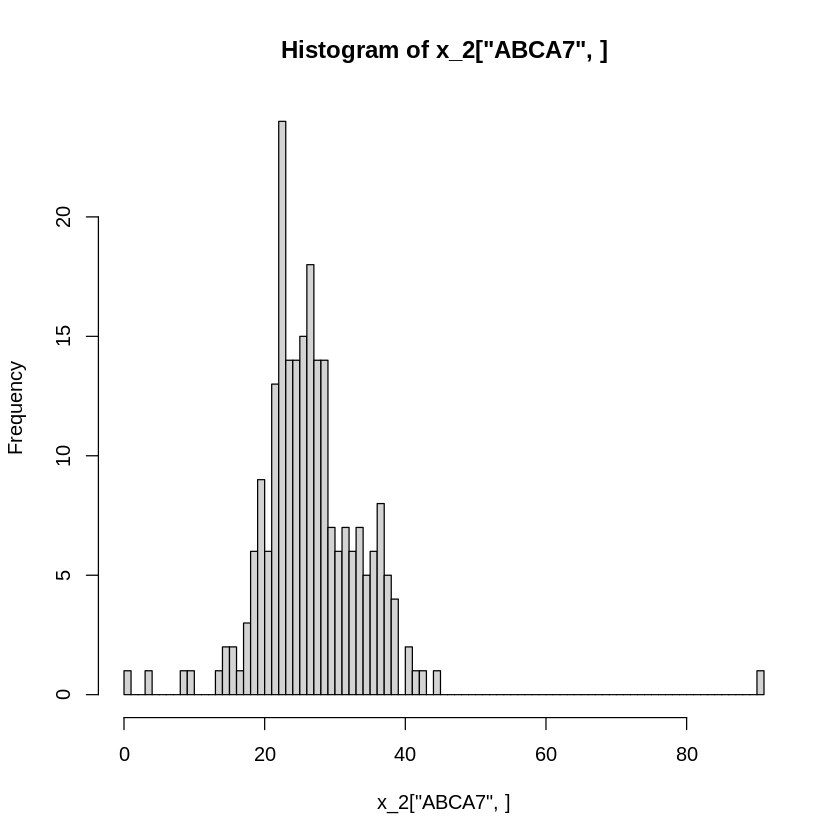

In [46]:
hist(x_2['ABCA7',], 100)

In [58]:
dim(counts_keep2)

[1] 10226   360

In [63]:
##### module activities / correlations
x = cpm(counts_keep2)#[,index])


In [64]:
write.csv(x, '../processed_data/common_var/cpm.csv')

In [83]:
gsva_out = read.csv( '../processed_data/common_var/gsva_out.csv', check.names=F, row.names=1)

In [86]:
gsva_out = t(gsva_out)

In [88]:
colnames(gsva_out) = paste0('cluster_', colnames(gsva_out))

In [91]:
meta_keep2_all = cbind(meta_keep2,gsva_out)

In [94]:
# functions
compute_degs = function (counts.df, mod1, mod0,var, n.sv = NULL)
{
    dge <- DGEList(cpm = counts.df)

    v <- voom(dge, design = mod1)
    if (is.null(n.sv)) {
        n.sv <- num.sv(v$E, mod1, method = "be")
    }
    svobj <- sva(v$E, mod1, mod0, n.sv = n.sv)
    mod1 <- cbind(mod1, svobj$sv)
    v <- voom(dge, design = mod1)
    fit <- lmFit(v, design = mod1)
    fit <- eBayes(fit)
    #res1 <- topTable(fit, coef = "rs3752246", n = Inf, sort.by = "p")
    res1 <- topTable(fit, coef =var, n = Inf, sort.by = "p")
    return(list(res1 = res1, C = svobj$sv, mod=mod1))
}

In [100]:
# compute DEGs rs3752246
# remove any LOF individuals


mod1 <- model.matrix(~cluster_7 + amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2_all)
fit <- lmFit(t(gsva_out), design = mod1)
fit <- eBayes(fit)
res1 <- topTable(fit, coef ='cluster_7', n = Inf, sort.by = "p")

In [101]:
res1

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cluster_7,1.00000000,-0.0410817028,6628.315929,0.000000e+00,0.000000e+00,1967.069634
cluster_3,0.45247716,-0.0262787036,18.888053,7.500030e-55,3.000012e-54,110.657345
cluster_4,-0.33500262,-0.0007279664,-7.830699,6.301710e-14,1.680456e-13,16.739955
cluster_0,0.11123921,-0.0035035512,4.611926,5.665383e-06,1.133077e-05,-1.177057
cluster_2,-0.15196944,-0.0151646820,-4.529103,8.219948e-06,1.315192e-05,-1.534649
cluster_5,0.15373868,-0.0134876483,3.843544,1.448277e-04,1.931036e-04,-4.270560
cluster_1,-0.14994698,0.0033988799,-3.047408,2.489771e-03,2.845453e-03,-6.927366
cluster_6,-0.08135637,-0.0138354532,-2.772155,5.876743e-03,5.876743e-03,-7.711013


In [98]:
dim(gsva_out)

[1] 360   8

In [ ]:
out = compute_degs(gsva_out, mod1, mod0, 'cluster_7')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

In [96]:
DGEList

function (counts = matrix(0, 0, 0), lib.size = colSums(counts), 
    norm.factors = rep(1, ncol(counts)), samples = NULL, group = NULL, 
    genes = NULL, remove.zeros = FALSE) 
{
    if (is.data.frame(counts)) {
        cl <- vapply(counts, class, FUN.VALUE = "")
        IsNumeric <- (cl %in% c("integer", "numeric"))
        a <- which(!IsNumeric)
        if (length(a)) {
            if (length(a) == 1L && a[1] == 1L) {
                stop("The count matrix is a data.frame instead of a matrix and the first column is of class ", 
                  cl[1], "\n", "  instead of being numeric. Was the first column intended to contain geneids?")
            }
            else {
                stop("The count matrix is a data.frame instead of a matrix and ", 
                  length(a), " columns are non-numeric.\n", "  Should these columns be gene annotation instead of counts?")
            }
        }
    }
    counts <- as.matrix(counts)
    if (!any(typeof(counts) == c("integer", "double"))) 
        stop("non-numeric values found in counts")
    nlib <- ncol(counts)
    ntags <- nrow(counts)
    if (nlib > 0L && is.null(colnames(counts))) 
        colnames(counts) <- paste0("Sample", 1L:nlib)
    if (ntags > 0L && is.null(rownames(counts))) 
        rownames(counts) <- 1L:ntags
    .isAllZero(counts)
    if (is.null(lib.size)) {
        lib.size <- colSums(counts)
        if (min(lib.size) <= 0) 
            warning("library size of zero detected")
    }
    else {
        if (!is.numeric(lib.size)) 
            stop("'lib.size' must be numeric")
        if (nlib != length(lib.size)) 
            stop("length of 'lib.size' must equal number of columns in 'counts'")
        minlibsize <- min(lib.size)
        if (is.na(minlibsize)) 
            stop("NA library sizes not allowed")
        if (minlibsize < 0) 
            stop("negative library sizes not permitted")
        if (minlibsize == 0) {
            if (any(lib.size == 0 & colSums(counts) > 0)) 
                stop("library size set to zero but counts are nonzero")
            warning("library size of zero detected")
        }
    }
    if (is.null(norm.factors)) {
        norm.factors <- rep_len(1, ncol(counts))
    }
    else {
        if (!is.numeric(norm.factors)) 
            stop("'lib.size' must be numeric")
        if (!identical(nlib, length(norm.factors))) 
            stop("Length of 'norm.factors' must equal number of columns in 'counts'")
        minnf <- min(norm.factors)
        if (is.na(minnf)) 
            stop("NA norm factors not allowed")
        if (minnf <= 0) 
            stop("norm factors should be positive")
        if (abs(prod(norm.factors) - 1) > 1e-06) 
            warning("norm factors don't multiply to 1")
    }
    if (!is.null(samples)) {
        samples <- as.data.frame(samples)
        if (nlib != nrow(samples)) 
            stop("Number of rows in 'samples' must equal number of columns in 'counts'")
    }
    if (is.null(group) && !is.null(samples$group)) {
        group <- samples$group
        samples$group <- NULL
    }
    if (is.null(group)) {
        group <- rep_len(1L, nlib)
        levels(group) <- "1"
        class(group) <- "factor"
    }
    else {
        if (length(group) != nlib) 
            stop("Length of 'group' must equal number of columns in 'counts'")
        group <- dropEmptyLevels(group)
    }
    sam <- data.frame(group = group, lib.size = lib.size, norm.factors = norm.factors)
    if (!is.null(samples)) 
        sam <- data.frame(sam, samples)
    samples <- sam
    if (anyDuplicated(colnames(counts))) {
        message("Repeated column names found in count matrix")
        row.names(samples) <- 1L:nlib
    }
    else row.names(samples) <- colnames(counts)
    x <- new("DGEList", list(counts = counts, samples = samples))
    if (!is.null(genes)) {
        genes <- as.data.frame(genes, stringsAsFactors = FALSE)
        if (nrow(genes) != ntags) 
            stop("Counts and genes have different numbers of

In [93]:
gsva_out

,cluster_2,cluster_5,cluster_4,cluster_0,cluster_1,cluster_6,cluster_7,cluster_3
11409232,0.23372218,0.2719115674,-0.29324721,0.054390925,-0.10552162,-0.245586309,0.67626148,0.446925655
11336574,-0.06007439,0.0428563090,-0.51139310,0.235229383,-0.21757672,0.033914502,0.72003611,0.581878503
20207013,0.18162946,0.4504847056,-0.24740398,-0.138706409,0.21325909,-0.204243542,0.63004570,0.585370549
10514454,0.19030084,0.0917205352,-0.00989614,-0.141785514,-0.29266654,-0.004327049,0.72724627,0.383659721
10290265,0.34948256,-0.2598405901,-0.03614310,-0.201197990,-0.25077468,-0.223494468,-0.25456933,-0.020213796
21412626,0.05850780,-0.1565084873,-0.47366921,-0.101946184,-0.38741523,-0.092353688,0.63626525,0.354262931
20170043,-0.12092703,-0.0552923620,0.08280909,-0.195736471,-0.16478794,-0.271408537,0.14891685,0.244042604
20956867,0.33159258,-0.2616555892,-0.20673902,0.007105114,-0.45326125,0.061481789,0.32544545,0.004163754
21172121,0.19273235,-0.0504222080,-0.20686294,-0.186265019,-0.11392434,-0.261425299,0.08732828,0.206001288
20104101,-0.03360207,0.2481844941,-0.45509051,0.000299052,-0.18754247,-0.138199435,0.77778705,0.551964441


In [61]:
#meta_keep2 = meta_keep2[index,]
meta_keep2$exp = x['ABCA7',]

In [60]:
x['ABCA7',]

11409232  11336574  20207013  10514454  10290265  20956867  21142003  20179164 
22.047390 17.717605 35.275567 33.205221 90.212755 25.752628 22.434471 19.386996 
 21159840  20977678  11310718  21135554  10101291  11399321  21272396  67429065 
 0.000000 31.730523 28.957946 32.035579 37.718212 35.551467 19.091647 20.812530 
 50106280  94430339  20646778  91444029  96095092  61827429  21001771  90780976 
 9.088751 26.125713 21.122282 19.309116 44.177816 35.767281 26.233634 23.465281 
 10684501  20993308  15218541  92629514  29933130  11681508  65652206  50403446 
22.237546 24.837693 26.045148 41.723670 34.785756 25.444817 17.222645 23.962738 
 83034844  98953007  95919181  50400835  20584923  21171080  34779151  70816595 
26.942510 22.903682 36.796847 35.168417 25.396056 22.637297 42.378311 30.678852 
 11619606  11632851  20780035  31509843  50109639  77891596  41773404  11259716 
18.222351 23.321465 26.462018 27.919765 25.769211 38.899540 28.942985 28.063773 
 10383017  43485807  62483327  66924745  36830117  10300914  43074402  21002524 
27.603558 27.910406 22.900953 32.971958 37.338138 36.577513 23.744016 36.937519 
 24039289  20143248  50101523  50107907  84642424  11165535  20344143  22776575 
33.974836 30.970577  3.508493 22.104471 24.791143 24.951191 35.049528 20.648239 
 82684406  50406057  50302554  20254876  50197261  10929637  15420223  15121461 
37.376911 25.461694 34.330106 30.231114 23.810118 19.108716 25.453685 32.668269 
 21112011  20970441  10253148  60848460  50402567  20611993  20974481  10249336 
25.712569 28.309271 38.649596 26.675289 23.057971 32.715208 24.505855 32.772932 
 50105699  50301387  21001933  10669174  11331231  10205244  11413170  11606935 
37.537288 28.287164 27.172045 36.079803 22.561945 20.818741 31.969785 29.336964 
 10202345  10271474  20156469  11652071  20124321  11326252  11616707  50105725 
36.568325 20.380893 28.223042 25.823619 18.495548 26.539444 25.517946 15.176275 
 50107583  33411712  50302004  50100806  10557081  20798913  11697592  11310844 
13.033892 24.564783 28.502554 33.408702 34.961849 25.023913 18.079951 22.008691 
 11157783  63188799  20583594  74753465  60725338  39989287  50402729  21001519 
31.345003 37.891776 22.746022 24.845671 27.274163 22.418651 21.153299 22.503501 
 10551157  20898476  50402693  65736039  52311825  21406920  23004922  83984043 
24.054911 32.215719 30.284062 26.578721 28.449878 19.507690 22.922755 28.560548 
 20263921  50405330  50107619  67185070  89903942  10510090  53772202  61029627 
23.680887 21.318706 23.807271 21.938077 22.530832 28.207099 21.209983 21.835080 
 18414513  69982533  66406040  91707643  20205705  31908032  10315029  87410220 
27.804255 24.852121 40.563712 23.299808 25.276879 23.718224 28.103556 36.124028 
 44299049  14184286  50405042  50301099  93815598  10292311  86408244  21193068 
36.817339 34.832968 27.958641 38.531725 25.911430 22.352346 27.726191 29.661112 
 20630946  50300408  50400385  20767628  50109927  64493027  90267190  20376029 
28.381752 31.230743 40.106838 29.661617 23.591129 20.127730 33.248446 24.885218 
 46000440  10516762  77143621  85065193  50102376  65292866  10901987  20195344 
22.468101 26.038420 29.887010 22.302351 25.501849 31.133213 27.378763 27.785170 
 20311676  11615242  10277308  20288196  20929774  11349119  20998065  50104008 
24.871402 19.349438 30.541239 31.254423 34.081725 23.812892 22.555179 15.591992 
 15738428  20904509  20225925  11430815  23690880  11327005  61142759  20569910 
17.816322 16.154943 14.441808 26.680184 21.925232 21.328269 21.043988 18.626654 
 21411323  45566083  20532115  57978756  10866165  75990666  32705437  84417209 
20.845495 23.580191 29.356146 25.623636 26.769149 29.515907 25.025967 27.515701 
 50401002  85171938  20682204  50106442  26631069  20139850  21401399  15844425 
24.060424 21.642408 22.347524 28.122890 23.646221 19.763258 22.354514 22.531442 
 50500136  46251007  34962204  50300084  20947550  16068769  37436329  52764842 
22.691875 26.084756 29.006558 27

In [62]:
write.csv(meta_keep2, '../processed_data/common_var/meta.csv')

In [56]:
library('GSVA')


ERROR: Error in library("GSVA"): there is no package called ‘GSVA’


In [ ]:
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      


In [11]:
### GSVA

x = cpm(counts_keep2)

out_bp_terms =gsva(as.matrix(x), P, mx.diff=TRUE, verbose=F, kcdf=c("Gaussian"), min.sz=5, max.sz = 150, parallel.sz=16)

   

,11409232,11336574,20207013,10514454,10290265,21412626,20170043,20956867,21172121,20104101,⋯,20730959,20500815,21402016,51624179,10100574,22789958,51520126,94144536,18659212,41285665
NOC2L,181,85,563,240,28,372,36,129,47,488,⋯,1277,1190,1152,991,1410,505,950,1260,846,653
KLHL17,19,6,55,42,4,45,6,37,3,44,⋯,171,157,277,188,467,131,236,335,283,128
HES4,58,11,121,94,6,96,6,60,6,172,⋯,6,1414,825,238,1746,163,736,794,450,350
AGRN,187,33,390,257,48,243,22,158,28,196,⋯,3,1060,1563,711,2575,756,1878,1724,1008,888
C1orf159,191,48,497,271,25,195,12,209,19,322,⋯,899,2392,2293,1462,3131,1303,2918,2558,2407,1781
SDF4,175,56,453,221,42,289,31,166,26,346,⋯,2083,1339,1318,1271,1788,704,1294,1706,1349,984
UBE2J2,136,47,434,218,23,230,22,155,41,380,⋯,1316,1134,1099,932,1780,730,1466,1700,1446,853
SCNN1D,23,7,116,53,11,42,6,39,10,40,⋯,144,98,324,172,450,282,460,405,500,291
ACAP3,391,99,1095,607,115,615,66,486,95,607,⋯,3525,2848,3915,2148,6214,2822,5478,4241,4492,2509
INTS11,232,84,662,358,61,318,40,154,75,487,⋯,2171,1709,1459,1382,2599,795,1421,2276,1616,943


### below is scrap

In [614]:
# compute DEGs rs3752246
# remove any LOF individuals

meta_keep2$rare_sums = ifelse(meta_keep2$rare_sums>0, 1, 0)

mod1 <- model.matrix(~rare_sums + amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)
mod0 <- model.matrix(~ amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)

out = compute_degs(counts_keep2, mod1, mod0, 'rare_sums')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [615]:
# compute fgsea results rs3752246
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [526]:
# compute DEGs weighted sum
meta_keep2$stage = ifelse(meta_keep2$stage3>0, 1, 0)


mod1 <- model.matrix(~weighted_sum + amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)
mod0 <- model.matrix(~ amyloid + nft + msex + age_death + apoe + pmi + seq_batch + niareagansc, data = meta_keep2)

out = compute_degs(counts_keep2, mod1, mod0, 'weighted_sum')
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [527]:
# compute fgsea results rs3752246
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)

In [616]:
o[order(o$pval,decreasing=FALSE),]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
7,0.004695886,0.03756708,0.31827968,0.5206892,1.7085514,40,"NDUFC1, ....",2.32828250
2,0.070724765,0.28289906,0.07902990,0.4483919,1.3966391,31,"HMGCS1, ....",1.15042849
4,0.354770017,0.69074890,0.03227336,0.3808170,1.0714465,20,"DDB2, LD....",0.45005309
5,0.414757709,0.69074890,0.02995854,0.3130458,1.0176332,38,"RBX1, MT....",0.38220553
1,0.440131820,0.69074890,0.02564854,-0.3165691,-1.0050959,38,"USP1, FA....",-0.35641723
6,0.558663413,0.69074890,0.02216700,-0.3482817,-0.9307757,18,"C2, MAX,....",-0.25284977
0,0.604405286,0.69074890,0.02346334,0.2804562,0.9116927,38,"IDH1, FH....",0.21867175
3,0.901162791,0.90116279,0.01454464,-0.2268536,-0.7395774,43,"IFT88, C....",-0.04519675


In [320]:
o[order(o$pval,decreasing=FALSE),]

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
7,0.1544625,0.9688118,0.05285003,0.3681119,1.2329730,40,"NDUFS3, ....",0.81117695
5,0.2480564,0.9688118,0.03618645,-0.3627033,-1.1502393,38,"POLE2, A....",-0.60544955
0,0.5640933,0.9688118,0.02142629,-0.2952470,-0.9363156,38,"KLKB1, G....",-0.24864906
3,0.5664034,0.9688118,0.02124791,-0.2876081,-0.9346628,43,"PSMD13, ....",-0.24687411
6,0.8723913,0.9688118,0.01762370,0.2559457,0.7067181,18,"PTRH2, B....",0.05928867
4,0.9600370,0.9688118,0.01389331,-0.2190239,-0.5998697,20,"LDLR, AP....",-0.01771203
1,0.9631170,0.9688118,0.01351410,-0.2031065,-0.6441109,38,"RNF168, ....",-0.01632096
2,0.9688118,0.9688118,0.01624148,0.1987398,0.6273882,31,"SIRT7, S....",0.01376059


In [39]:

# add variant info 
temp = data$var_info

rs729 = temp[temp['ID']=='rs72973581','POS']
rs375 = temp[temp['ID']=='rs3752246','POS']

#meta_keep$rs3752246_1 = ifelse(meta_keep[,'1056492']=='0/1', 1, 0)
meta_keep$rs3752246_2 = ifelse(meta_keep[,'1056492']!='1/1', 1, 0)
#meta_keep$rs72973581 = ifelse(meta_keep[,'1043103']=='0/0', 0, ifelse(meta_keep[,'1043103']=='0/1', 1, 2))
print(table(meta_keep$rs3752246_2))
meta_keep = meta_keep[,c('amyloid', 'nft', 'msex', 'age_death', 'pmi', 'seq_batch', 'apoe_genotype', 'rs3752246_2', 'niareagansc')]

# filter
keep = rowSums(is.na(meta_keep))==0 #& meta_keep$niareagansc%in%(unlist(list('3','4')))
meta_keep2 = meta_keep[keep,]
meta_keep2$apoe = ifelse(meta_keep2$apoe_genotype%in%c(34,44,24), 1, 0)
counts_keep2 = counts_indexed[,keep]

counts_keep2 = counts_keep2[rownames(counts_keep2)%in%expressed$Ex & rowSums(counts_keep2>0)>15,]

# compute DEGs
out = compute_degs(counts_keep2, meta_keep2)
curr = out$res1
scores = sign(curr$logFC) * -log10(curr$P.Value)
names(scores) = rownames(curr)
scores = scores[order(scores, decreasing = TRUE)]

# compute fgsea results
paths = read.csv('../supplementary_tables/data_s8.csv')
paths = paths[paths$is_gene=='True',]
P = list()
for(i in unique(paths$cluster)){
    P[[as.character(i)]] = paths[paths$cluster==i,'description']
}      

o = fgsea(pathways = P, stats = scores, minSize = 5, maxSize = 1000, nproc=1, nPermSimple=10000)
o = o[order(o$pval,decreasing=T),]
o$score = sign(o$NES) * -log10(o$pval)
o$pathway = factor(o$pathway, levels = o$pathway)


  0   1 
241 136 
Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

In [41]:
write.csv(as.data.frame(scores), '../processed_data/common_var/ex_scoresE4.csv')

In [40]:
o

pathway,pval,padj,log2err,ES,NES,size,leadingEdge,score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>,<dbl>
4,0.92600798,0.9260080,0.01702552,-0.2343931,-0.6639091,20,"MDM2, RP....",-0.03338527
6,0.59560842,0.6806953,0.02077039,0.3407706,0.9079523,18,"CASP3, T....",0.22503917
0,0.50579965,0.6743995,0.02269799,0.3050356,0.9682053,38,"CLU, C1S....",0.29602148
1,0.42442882,0.6743995,0.02557152,0.3212969,1.0198197,38,"MRE11, T....",0.37219513
2,0.35261708,0.6743995,0.03387289,-0.3369552,-1.0653238,31,"NCOA1, E....",-0.45269666
5,0.17532468,0.4675325,0.05046611,-0.3631470,-1.2005879,38,"RPA2, DN....",-0.75615696
3,0.13079275,0.4675325,0.05948707,-0.3691121,-1.2493702,43,"PSMA7, P....",-0.88341631
7,0.08743043,0.4675325,0.07293884,-0.3908773,-1.3069889,40,"NDUFB8, ....",-1.05833740


In [348]:
rs729

[1] 1043103

In [352]:
table(meta_keep2$rs3752246, meta_keep2$rs72973581)

   
      0   1
  0 202  38
  1 111   7
  2  17   0

In [213]:
375/20

[1] 18.75

In [333]:
dim(counts_keep2)

[1] 10226   375

In [201]:
dim(counts_keep2)

[1] 10214   375

Number of significant surrogate variables is:  21 
Iteration (out of 5 ):1  2  3  4  5  

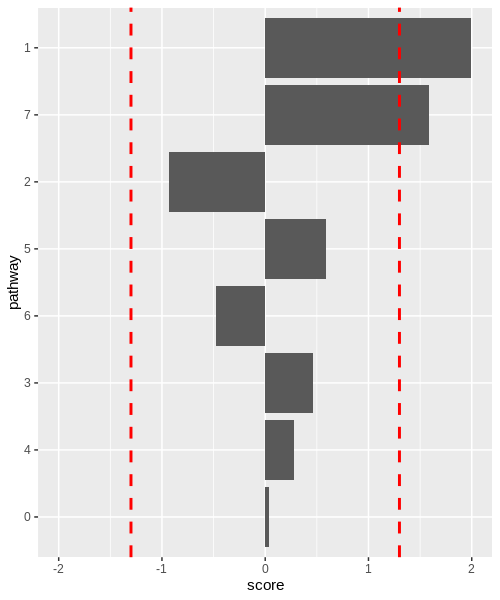

In [361]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1.3,1.3), linetype="dashed", 
                color = "red", size=1)

In [ ]:
# analysis of dose dependency
# show effect size as in figure 2
# missense burden variant analysis as in Holstege et al 

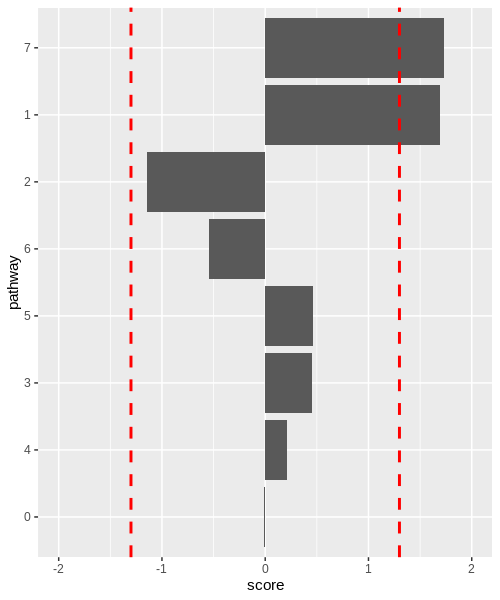

In [340]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1.3,1.3), linetype="dashed", 
                color = "red", size=1)

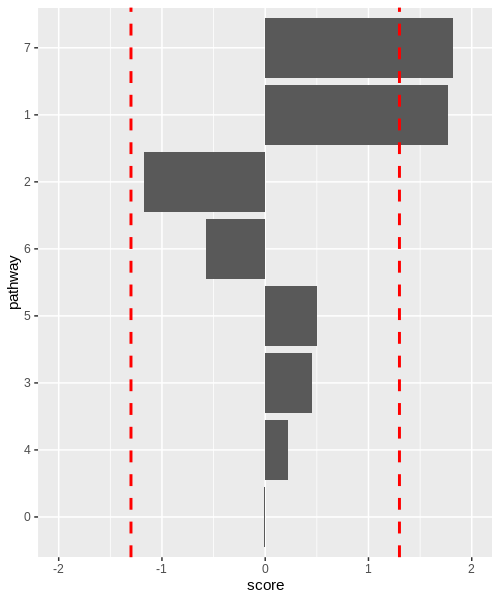

In [259]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1.3,1.3), linetype="dashed", 
                color = "red", size=1)

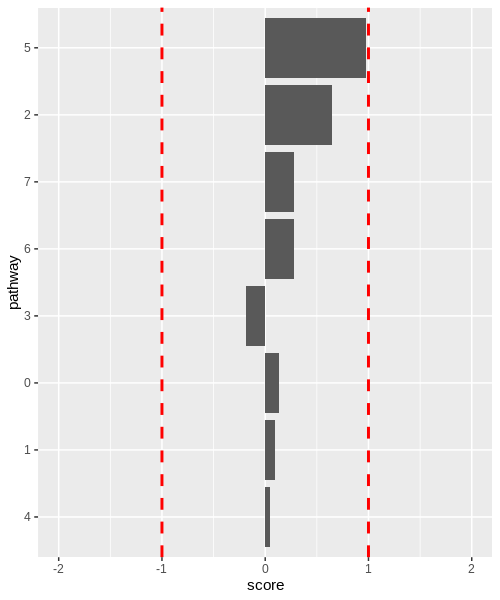

In [242]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


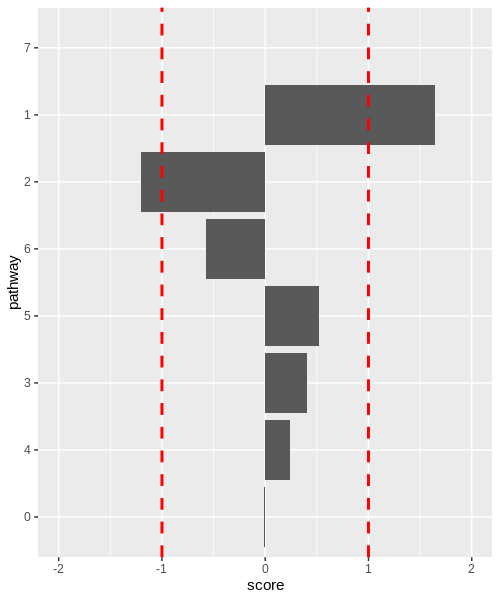

In [208]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

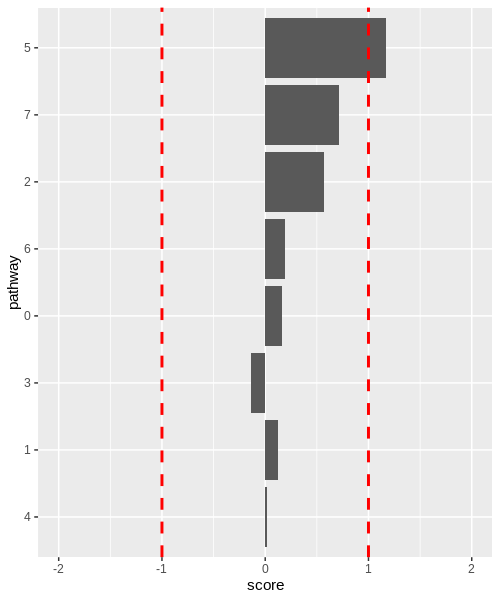

In [190]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

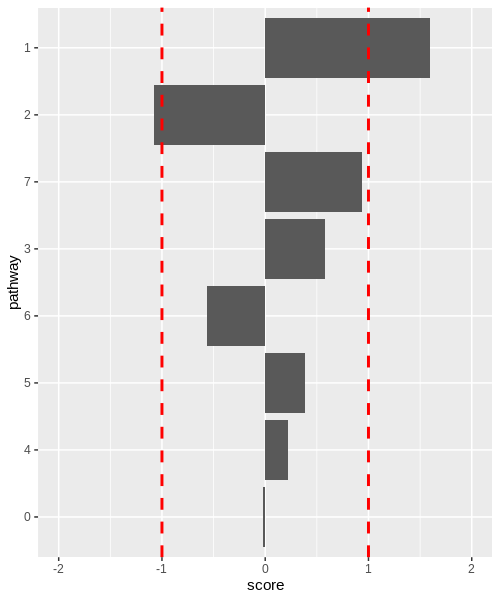

In [141]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

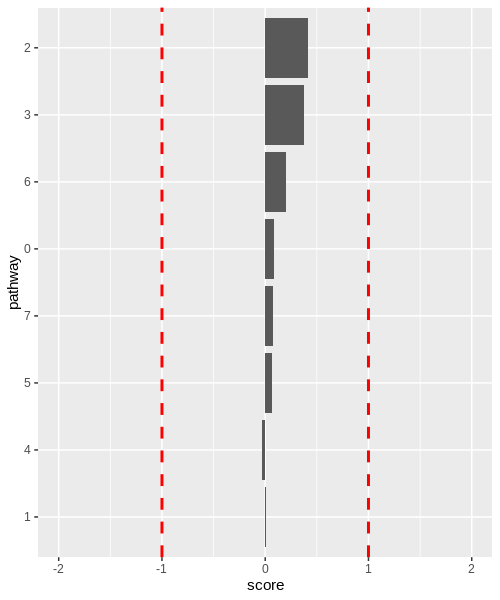

In [117]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

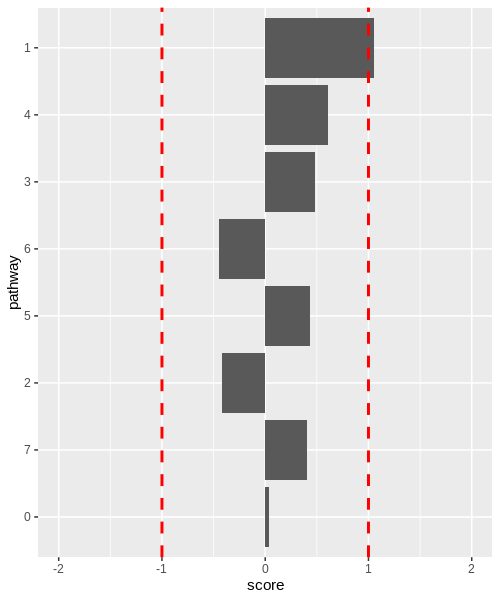

In [101]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)

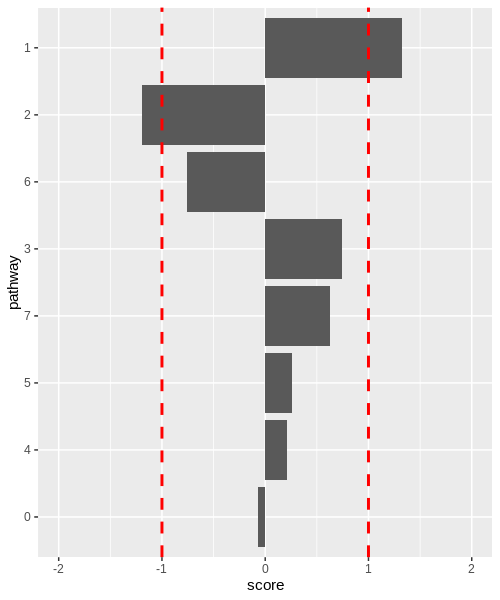

In [66]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height =6, repr.plot.res = 100)

ggplot(o, aes(x=pathway, y=score)) + 
  geom_bar(stat = "identity") +
  coord_flip() + ylim(c(-2,2))+ geom_hline(yintercept=c(-1,1), linetype="dashed", 
                color = "red", size=1)